In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import (accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef, precision_score)


# Ipython display facilities
from IPython.display import HTML, display
import tabulate


In [2]:
df=pd.read_csv('heart.csv')

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


In [5]:
#checking the null values
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending = False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls[:15]

,Null Count
Feature,
target,0
thal,0
ca,0
slope,0
oldpeak,0
exang,0
thalach,0
restecg,0
fbs,0


In [6]:
# Prepare training and test sets
target = 'target'

features = df.columns.tolist()
features.remove(target)
print(features, len(features), target)

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'] 13 target


In [7]:
# Note: may want to check this. else rename as done in other regression script, as below:
X = df[features]
y = df[target]

print(X.shape, y.shape)

(303, 13) (303,)


skew is -0.17982105403495655


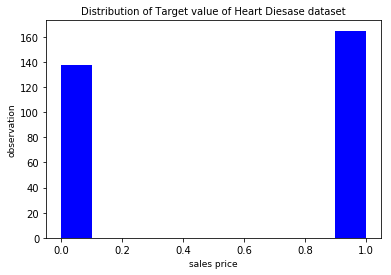

In [8]:
#analysing the distribution of Target
print('skew is', df.target.skew())   
plt.hist(df['target'], color= 'b')

plt.title('Distribution of Target value of Heart Diesase dataset', fontsize = 10)
plt.ylabel('observation', fontsize = 9)
plt.xlabel('sales price', fontsize = 9)

plt.show()

In [9]:
#log transforming sale price to transform it into gaussian distribution
target2 = np.log(df.target)

C:\Users\SATIP PADHY\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [10]:
#features with the most correlation with the predictor variable
corr = df.corr()
print(corr['target'].sort_values(ascending = False)[:5], '\n')
print(corr['target'].sort_values(ascending = False)[-5:])

target     1.000000
cp         0.433798
thalach    0.421741
slope      0.345877
restecg    0.137230
Name: target, dtype: float64 

sex       -0.280937
thal      -0.344029
ca        -0.391724
oldpeak   -0.430696
exang     -0.436757
Name: target, dtype: float64


In [11]:
#pivot table of Overall CP & Target
quality_pivot = df.pivot_table(index= 'cp', values= 'target')

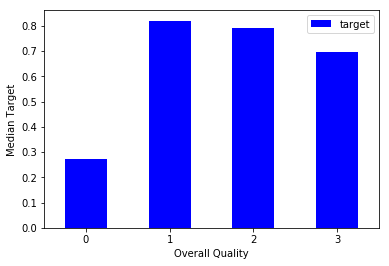

In [12]:
#plotting the pivot table
quality_pivot.plot(kind = 'bar', color = 'blue')

plt.xlabel('Overall Quality')
plt.ylabel('Median Target')
plt.xticks(rotation = 0)
plt.show()

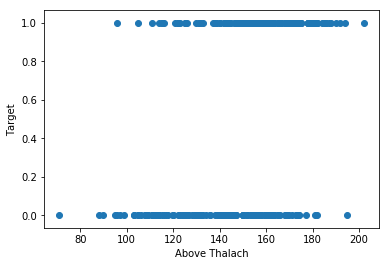

In [13]:
#Analysing the feature - Thalah 
plt.scatter(x = df['thalach'], y = df['target'])

plt.xlabel('Above Thalach')
plt.ylabel('Target')
plt.show()

In [14]:
# Generic all-in-one function to train an sklearn estimator and return the corresponding metrics for the training and test sets
#
def compute_classification_metrics(name, estimator, X_train, y_train, X_test, y_test, display_plots=False):
    # Train model
    estimator.fit(X_train, y_train)
    
    # Compute MSE and RSME for both training and test data
    train_predictions = estimator.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions) 
    train_precision = precision_score(y_train, train_predictions)
    train_recall = recall_score(y_train, train_predictions)
    train_f1 = f1_score(y_train, train_predictions)
    train_mcc = matthews_corrcoef(y_train, train_predictions)

    test_predictions = estimator.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions) 
    test_precision = accuracy_score(y_test, test_predictions) 
    test_recall = recall_score(y_test, test_predictions) 
    test_f1 = f1_score(y_test, test_predictions)
    test_mcc = matthews_corrcoef(y_test, test_predictions)

    return train_accuracy, train_precision, train_recall, train_f1, train_mcc, test_accuracy, test_precision, test_recall, test_f1, test_mcc


In [15]:
# Instantiate sklearn binary classification estimators

# KNearestNeighbors -  https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
knn = KNeighborsClassifier(3) 

# Linear SVM  -  https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html NB kernel parameter, among others - as in the ff rbf
lsvm = SVC(kernel="linear", C=0.025)

# RBF SVM - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html NB kernel parameter, among others
rbfsvm = SVC(gamma=2, C=1)

# GaussianProcess   - https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html
gp = GaussianProcessClassifier(1.0 * RBF(1.0))   

# Decision Tree - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
tree = DecisionTreeClassifier(max_depth=5) 

# Random Forest - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)

# Neural network - https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
neural_net = MLPClassifier(alpha=1)

# Ada Boost - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
ada_boost = AdaBoostClassifier()

# Naive Bayes - https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
naive_bayes = GaussianNB()

# QDA- https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html
qda = QuadraticDiscriminantAnalysis()

estimators = {
    "KNearestNeighbors": knn,
    "LinearSVM": lsvm,
    "RBFSVM": rbfsvm,
    "GaussianProcess": gp,
    "Decision Tree": tree,
    "Random Forest": forest,
    "Neural network": neural_net,
    "Ada Boost": ada_boost,
    "Naive Bayes": naive_bayes,
    "QDA": qda
}


In [16]:
# Running the model with training and testing with an external loop to perform training and test k times. 

k = 10   # several files were run with 2, 5, 10, 15, 20. Standard is 10. Might repeat to check behaviour of metrics (Acc etc Vs. Nr. iterations)

for i in range(1, k):           
    
    # makes sense to avid identical results by changing seed for each repetition of the lot (take k) instead of running:  np.random.seed(None)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=np.random.RandomState(seed=None))  # shuffled but not stratified
    # Train, predict and compute metrics for each estimator
        
    metrics = [["Estimator", "Training Acc", "Training Precision", "Training Recall", "Training F1", "Training MCC", 
            "Test Acc", "Test Precision", "Test Recall", "Test F1", "Test MCC"]]
    
    for name, estimator in estimators.items():
        print("Current estimator: {}".format(name))
        
        # tuple added as a list to the table
        trn_acc, trn_prec, trn_rec, trn_f1, trn_mcc, tst_acc, tst_prec, tst_rec, tst_f1, tst_mcc = compute_classification_metrics(name, estimator, X_train, y_train, X_test, y_test)
      
        # metrics.append([name, estimator, trn_acc, trn_prec, trn_rec, trn_f1, trn_mcc, tst_acc, tst_prec, tst_rec, tst_f1, tst_mcc ]) 
        metrics.append([name, trn_acc, trn_prec, trn_rec, trn_f1, trn_mcc, tst_acc, tst_prec, tst_rec, tst_f1, tst_mcc ]) 
        
        print( i)   # just to see where we are
        # metrics.append([name, *(plot_and_compute_classification_metrics(name, estimator, X_train, y_train, X_test, y_test))])
    
    
    # May have an issue about too many open windows if we pre- plot massively  - in this case, brutally close current - or all - window/s
    # plt.close() # current window
    # plt.close('all')  # all open figures.    
       


# finished estimator loop and the number of times (k) loop, so 
# 1. may want to see global table for debugging:
# display(HTML(tabulate.tabulate(metrics, tablefmt='html', headers='firstrow')))

# 2. append to dataframe then group by - metr_df is the dataframe for the global stats
metr_df = pd.DataFrame(metrics[1:], columns=["Estimator", "Training Acc", "Training Precision", "Training Recall", "Training F1", "Training MCC", 
            "Test Acc", "Test Precision", "Test Recall", "Test F1", "Test MCC"])     

Current estimator: KNearestNeighbors
1
Current estimator: LinearSVM
1
Current estimator: RBFSVM
1
Current estimator: GaussianProcess


C:\Users\SATIP PADHY\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


1
Current estimator: Decision Tree
1
Current estimator: Random Forest
1
Current estimator: Neural network
1
Current estimator: Ada Boost
1
Current estimator: Naive Bayes
1
Current estimator: QDA
1
Current estimator: KNearestNeighbors
2
Current estimator: LinearSVM
2
Current estimator: RBFSVM
2
Current estimator: GaussianProcess


C:\Users\SATIP PADHY\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2
Current estimator: Decision Tree
2
Current estimator: Random Forest
2
Current estimator: Neural network


C:\Users\SATIP PADHY\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2
Current estimator: Ada Boost
2
Current estimator: Naive Bayes
2
Current estimator: QDA
2
Current estimator: KNearestNeighbors
3
Current estimator: LinearSVM
3
Current estimator: RBFSVM
3
Current estimator: GaussianProcess


C:\Users\SATIP PADHY\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


3
Current estimator: Decision Tree
3
Current estimator: Random Forest
3
Current estimator: Neural network
3
Current estimator: Ada Boost
3
Current estimator: Naive Bayes
3
Current estimator: QDA
3
Current estimator: KNearestNeighbors
4
Current estimator: LinearSVM
4
Current estimator: RBFSVM
4
Current estimator: GaussianProcess


C:\Users\SATIP PADHY\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


4
Current estimator: Decision Tree
4
Current estimator: Random Forest
4
Current estimator: Neural network
4
Current estimator: Ada Boost
4
Current estimator: Naive Bayes
4
Current estimator: QDA
4
Current estimator: KNearestNeighbors
5
Current estimator: LinearSVM
5
Current estimator: RBFSVM
5
Current estimator: GaussianProcess


C:\Users\SATIP PADHY\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


5
Current estimator: Decision Tree
5
Current estimator: Random Forest
5
Current estimator: Neural network
5
Current estimator: Ada Boost
5
Current estimator: Naive Bayes
5
Current estimator: QDA
5
Current estimator: KNearestNeighbors
6
Current estimator: LinearSVM
6
Current estimator: RBFSVM
6
Current estimator: GaussianProcess


C:\Users\SATIP PADHY\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


6
Current estimator: Decision Tree
6
Current estimator: Random Forest
6
Current estimator: Neural network
6
Current estimator: Ada Boost
6
Current estimator: Naive Bayes
6
Current estimator: QDA
6
Current estimator: KNearestNeighbors
7
Current estimator: LinearSVM
7
Current estimator: RBFSVM
7
Current estimator: GaussianProcess


C:\Users\SATIP PADHY\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


7
Current estimator: Decision Tree
7
Current estimator: Random Forest
7
Current estimator: Neural network
7
Current estimator: Ada Boost
7
Current estimator: Naive Bayes
7
Current estimator: QDA
7
Current estimator: KNearestNeighbors
8
Current estimator: LinearSVM
8
Current estimator: RBFSVM
8
Current estimator: GaussianProcess


C:\Users\SATIP PADHY\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


8
Current estimator: Decision Tree
8
Current estimator: Random Forest
8
Current estimator: Neural network
8
Current estimator: Ada Boost
8
Current estimator: Naive Bayes
8
Current estimator: QDA
8
Current estimator: KNearestNeighbors
9
Current estimator: LinearSVM
9
Current estimator: RBFSVM
9
Current estimator: GaussianProcess


C:\Users\SATIP PADHY\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


9
Current estimator: Decision Tree
9
Current estimator: Random Forest
9
Current estimator: Neural network
9
Current estimator: Ada Boost
9
Current estimator: Naive Bayes
9
Current estimator: QDA
9


In [17]:
# Gather metrics in a common table
display(HTML(tabulate.tabulate(metrics, tablefmt='html', headers='firstrow')))

Estimator,Training Acc,Training Precision,Training Recall,Training F1,Training MCC,Test Acc,Test Precision,Test Recall,Test F1,Test MCC
KNearestNeighbors,0.768868,0.775,0.808696,0.791489,0.5331,0.681319,0.681319,0.82,0.738739,0.351597
LinearSVM,0.853774,0.823077,0.930435,0.873469,0.709236,0.791209,0.791209,0.92,0.828829,0.586511
RBFSVM,1,1,1,1,1,0.549451,0.549451,1,0.70922,0
GaussianProcess,1,1,1,1,1,0.571429,0.571429,0.64,0.621359,0.128942
Decision Tree,0.957547,0.964912,0.956522,0.960699,0.914588,0.714286,0.714286,0.78,0.75,0.419501
Random Forest,0.929245,0.916667,0.956522,0.93617,0.857862,0.769231,0.769231,0.82,0.796117,0.532009
Neural network,0.801887,0.741722,0.973913,0.842105,0.62931,0.714286,0.714286,0.98,0.790323,0.472634
Ada Boost,0.943396,0.947826,0.947826,0.947826,0.88597,0.681319,0.681319,0.76,0.72381,0.351418
Naive Bayes,0.853774,0.833333,0.913043,0.871369,0.706727,0.758242,0.758242,0.78,0.78,0.511707
QDA,0.900943,0.905172,0.913043,0.909091,0.800323,0.703297,0.703297,0.72,0.727273,0.402143


In [18]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

data = [
        go.Bar(name="age", y=df.age, x=df.target),
        go.Bar(name="sex", y=df.sex, x=df.target),
        go.Bar(name="cp", y=df.cp, x=df.target),
        go.Bar(name="trestbps", y=df.trestbps, x=df.target),
        go.Bar(name="chol", y=df.chol, x=df.target),
        go.Bar(name="fbs", y=df.fbs, x=df.target),
        go.Bar(name="restecg", y=df.restecg, x=df.target),
        go.Bar(name="thalach", y=df.thalach, x=df.target),
        go.Bar(name="exang", y=df.exang, x=df.target),
        go.Bar(name="oldpeak", y=df.oldpeak, x=df.target),
        go.Bar(name="slope", y=df.slope, x=df.target),
        go.Bar(name="ca", y=df.ca, x=df.target),
        go.Bar(name="thal", y=df.thal, x=df.target)
    # 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'
]

layout = go.Layout(
    title='Distibution of Data along with Target variable on raw data'
)

fig = go.Figure(data=data, layout=layout)

plot_url = py.iplot(fig)
#plot_url = py.iplot(data)

In [19]:
metr_df.rename(columns={'Training Acc':'TrainingAcc', 'Training Precision':'TrainingPrecision', 'Training Recall':'TrainingRecall', 'Training F1':'TrainingF1', 'Training MCC':'TrainingMCC', 'Test Acc':'TestAcc', 'Test Precision':'TestPrecision', 'Test Recall':'TestRecall', 'Test F1':'TestF1', 'Test MCC':'TestMCC'}, inplace=True)

In [20]:
metr_df

,Estimator,TrainingAcc,TrainingPrecision,TrainingRecall,TrainingF1,TrainingMCC,TestAcc,TestPrecision,TestRecall,TestF1,TestMCC
0,KNearestNeighbors,0.768868,0.775000,0.808696,0.791489,0.533100,0.681319,0.681319,0.82,0.738739,0.351597
1,LinearSVM,0.853774,0.823077,0.930435,0.873469,0.709236,0.791209,0.791209,0.92,0.828829,0.586511
2,RBFSVM,1.000000,1.000000,1.000000,1.000000,1.000000,0.549451,0.549451,1.00,0.709220,0.000000
3,GaussianProcess,1.000000,1.000000,1.000000,1.000000,1.000000,0.571429,0.571429,0.64,0.621359,0.128942
4,Decision Tree,0.957547,0.964912,0.956522,0.960699,0.914588,0.714286,0.714286,0.78,0.750000,0.419501
5,Random Forest,0.929245,0.916667,0.956522,0.936170,0.857862,0.769231,0.769231,0.82,0.796117,0.532009
6,Neural network,0.801887,0.741722,0.973913,0.842105,0.629310,0.714286,0.714286,0.98,0.790323,0.472634
7,Ada Boost,0.943396,0.947826,0.947826,0.947826,0.885970,0.681319,0.681319,0.76,0.723810,0.351418
8,Naive Bayes,0.853774,0.833333,0.913043,0.871369,0.706727,0.758242,0.758242,0.78,0.780000,0.511707
9,QDA,0.900943,0.905172,0.913043,0.909091,0.800323,0.703297,0.703297,0.72,0.727273,0.402143


In [21]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

data = [
        go.Bar(name="Training Acc", y=metr_df.TrainingAcc, x=metr_df.Estimator),
        go.Bar(name="Training Precision", y=metr_df.TrainingPrecision, x=metr_df.Estimator),
        go.Bar(name="Training Recall", y=metr_df.TrainingRecall, x=metr_df.Estimator),
        go.Bar(name="Training F1", y=metr_df.TrainingF1, x=metr_df.Estimator),
        go.Bar(name="Training MCC", y=metr_df.TrainingMCC, x=metr_df.Estimator),
        go.Bar(name="Test Acc", y=metr_df.TestAcc, x=metr_df.Estimator),
        go.Bar(name="Test Precision", y=metr_df.TestPrecision, x=metr_df.Estimator),
        go.Bar(name="Test Recall", y=metr_df.TestRecall, x=metr_df.Estimator),
        go.Bar(name="Test F1", y=metr_df.TestF1, x=metr_df.Estimator),
        go.Bar(name="Test MCC", y=metr_df.TestMCC, x=metr_df.Estimator),
        
    
]

layout = go.Layout(
    title='Distibution of Metrics data after building a Classification Models with Estimator variable'
)

fig = go.Figure(data=data, layout=layout)

plot_url = py.iplot(fig)
#plot_url = py.iplot(data)

In [22]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

data = [
        go.Scatter(name="Training Acc", y=metr_df.TrainingAcc, x=metr_df.Estimator),
        go.Scatter(name="Training Precision", y=metr_df.TrainingPrecision, x=metr_df.Estimator),
        go.Scatter(name="Training Recall", y=metr_df.TrainingRecall, x=metr_df.Estimator),
        go.Scatter(name="Training F1", y=metr_df.TrainingF1, x=metr_df.Estimator),
        go.Scatter(name="Training MCC", y=metr_df.TrainingMCC, x=metr_df.Estimator),
        go.Scatter(name="Test Acc", y=metr_df.TestAcc, x=metr_df.Estimator),
        go.Scatter(name="Test Precision", y=metr_df.TestPrecision, x=metr_df.Estimator),
        go.Scatter(name="Test Recall", y=metr_df.TestRecall, x=metr_df.Estimator),
        go.Scatter(name="Test F1", y=metr_df.TestF1, x=metr_df.Estimator),
        go.Scatter(name="Test MCC", y=metr_df.TestMCC, x=metr_df.Estimator),
        
    
]

layout = go.Layout(
    title='Distibution of Metrics data after building a Classification Models with Estimator variable'
)

fig = go.Figure(data=data, layout=layout)

plot_url = py.iplot(fig)
#plot_url = py.iplot(data)

In [23]:
from sklearn.ensemble import ExtraTreesClassifier
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [24]:
importances = forest.feature_importances_

In [25]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

In [26]:
indices = np.argsort(importances)[::-1]

Feature ranking:
1. feature 2 (0.122016)
2. feature 12 (0.110501)
3. feature 11 (0.104969)
4. feature 8 (0.104438)
5. feature 9 (0.095960)
6. feature 7 (0.079836)
7. feature 1 (0.078502)
8. feature 0 (0.067148)
9. feature 3 (0.062743)
10. feature 10 (0.062620)
11. feature 4 (0.052302)
12. feature 6 (0.036999)
13. feature 5 (0.021963)


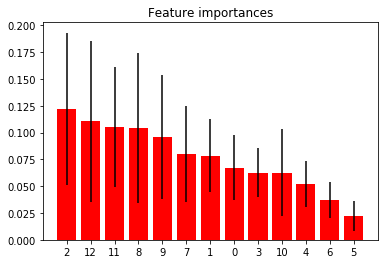

In [27]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [31]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Test Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test, y_test)))

R^2 Training Score: 0.93 
OOB Score: 0.51 
R^2 Test Score: 0.39


In [35]:
X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,212.0,54.523585,9.127034,29.0,47.75,55.0,61.00,76.0
sex,212.0,0.693396,0.462175,0.0,0.00,1.0,1.00,1.0
cp,212.0,0.990566,1.030302,0.0,0.00,1.0,2.00,3.0
trestbps,212.0,132.132075,17.546188,94.0,120.00,130.0,140.00,200.0
chol,212.0,243.641509,54.050124,126.0,211.00,240.0,270.00,564.0
fbs,212.0,0.160377,0.367824,0.0,0.00,0.0,0.00,1.0
restecg,212.0,0.528302,0.528030,0.0,0.00,1.0,1.00,2.0
thalach,212.0,147.948113,23.151513,88.0,131.00,151.0,164.25,202.0
exang,212.0,0.320755,0.467871,0.0,0.00,0.0,1.00,1.0
oldpeak,212.0,1.034906,1.146273,0.0,0.00,0.8,1.60,6.2


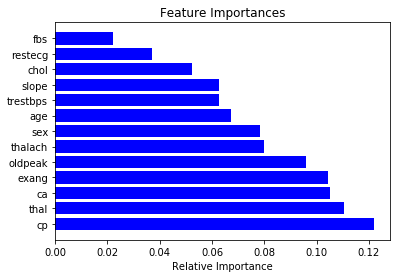

In [43]:
features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
#importances = rnd_clf.feature_importances_
#indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [44]:
"""# Barplot: Add bars
plt.bar(range(X.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), rotation=20, fontsize = 8)
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()"""

'# Barplot: Add bars\nplt.bar(range(X.shape[1]), importances[indices])\n# Add feature names as x-axis labels\nplt.xticks(range(X.shape[1]), rotation=20, fontsize = 8)\n# Create plot title\nplt.title("Feature Importance")\n# Show plot\nplt.show()'